In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
import sys
import warnings
import datetime
import tkinter as tk
from tkinter import messagebox
warnings.filterwarnings("ignore")

# Load the data
file_path = 'D:\\FRAUD\\bank_transactions_data_2.csv'
df = pd.read_csv(file_path,low_memory=False)

# Convert TransactionDate to datetime
df['TransactionDate'] = pd.to_datetime(df['TransactionDate'])

# Sort by TransactionDate
df = df.sort_values(by='TransactionDate')

dfa=df.drop_duplicates()

Number of transactions with anomalies detected by BoxPlot 5% range: 126
Number of transactions with anomalies detected by Isolation Forest: 126
Cross-validated anomalies:
     TransactionID AccountID  TransactionAmount     TransactionDate  \
427       TX000341   AC00107            1830.00 2023-01-03 16:31:00   
104       TX000487   AC00148            1416.69 2023-01-16 17:00:00   
122       TX001610   AC00273            1431.33 2023-01-17 17:50:00   
165       TX001918   AC00382            1427.71 2023-01-24 17:26:00   
1420      TX002130   AC00304            1154.79 2023-02-08 17:52:00   
...            ...       ...                ...                 ...   
2425      TX000275   AC00454            1176.28 2023-12-20 16:08:00   
2434      TX001214   AC00170            1192.20 2023-12-21 16:21:00   
2459      TX002243   AC00252            1169.59 2023-12-25 17:12:00   
2466      TX001248   AC00071            1647.74 2023-12-25 17:41:00   
2506      TX001880   AC00460               0.84 

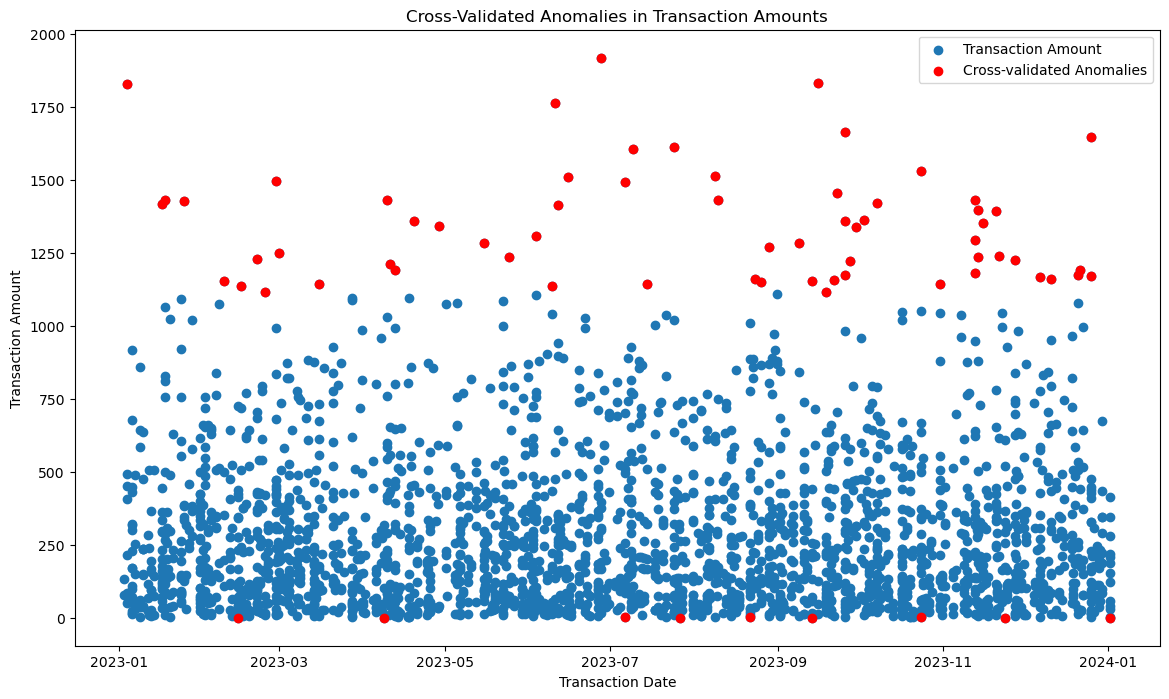

In [2]:
# Calculate the 2.5th and 97.5th percentiles
lower_bound = df['TransactionAmount'].quantile(0.025)
upper_bound = df['TransactionAmount'].quantile(0.975)

# Detect anomalies based on the 5% range
df['Boxplot_5percent_Anomaly'] = (df['TransactionAmount'] < lower_bound) | (df['TransactionAmount'] > upper_bound)

# Apply Isolation Forest
X = df[['TransactionAmount']]
model = IsolationForest(contamination=0.05, random_state=42)
df['IsolationForest_Anomaly'] = model.fit_predict(X)
df['IsolationForest_Anomaly'] = df['IsolationForest_Anomaly'].apply(lambda x: True if x == -1 else False)

num_transactions_with_boxplot_anomalies = df[df['Boxplot_5percent_Anomaly'] == True].shape[0]
print(f'Number of transactions with anomalies detected by BoxPlot 5% range: {num_transactions_with_boxplot_anomalies}')
num_transactions_with_isolation_anomalies = df[df['IsolationForest_Anomaly'] == True].shape[0]
print(f'Number of transactions with anomalies detected by Isolation Forest: {num_transactions_with_isolation_anomalies}')

# Cross-validate anomalies
df['CrossValidated_Anomaly'] = df['Boxplot_5percent_Anomaly'] & df['IsolationForest_Anomaly']

# Print the cross-validated anomalies
cross_validated_anomalies = df[df['CrossValidated_Anomaly'] == True]
print("Cross-validated anomalies:")
print(cross_validated_anomalies)

# Save the filtered DataFrame to an Excel file
cross_validated_anomalies.to_excel('D:\\FRAUD\\cross_validated_anomalies.xlsx', index=False)

# Plot anomalies for visualization
plt.figure(figsize=(14, 8))
plt.scatter(df['TransactionDate'], df['TransactionAmount'], label='Transaction Amount')
plt.scatter(df['TransactionDate'][df['CrossValidated_Anomaly']], df['TransactionAmount'][df['CrossValidated_Anomaly']], color='red', label='Cross-validated Anomalies')
plt.title('Cross-Validated Anomalies in Transaction Amounts')
plt.xlabel('Transaction Date')
plt.ylabel('Transaction Amount')
plt.legend()
plt.show()

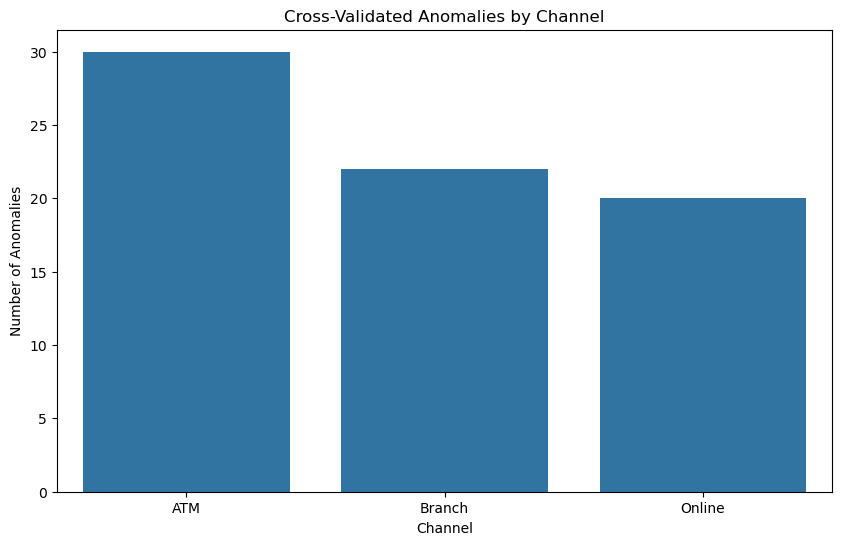

In [3]:
# Plot the cross-validated anomalies by Channel
plt.figure(figsize=(10, 6))
cross_validated_anomalies_by_channel = df[df['CrossValidated_Anomaly'] == True]['Channel'].value_counts()
sns.barplot(x=cross_validated_anomalies_by_channel.index, y=cross_validated_anomalies_by_channel.values)
plt.title('Cross-Validated Anomalies by Channel')
plt.xlabel('Channel')
plt.ylabel('Number of Anomalies')
plt.show()

In [4]:
# Create a dummy 'True_Anomaly' column for demonstration
np.random.seed(0)  # For reproducibility
df['True_Anomaly'] = np.random.choice([True, False], size=len(df), p=[0.05, 0.95])

# Calculate precision for 5% range anomalies
true_positives_5percent = sum((df['Boxplot_5percent_Anomaly'] == True) & (df['True_Anomaly'] == True))
false_positives_5percent = sum((df['Boxplot_5percent_Anomaly'] == True) & (df['True_Anomaly'] == False))
precision_5percent = true_positives_5percent / (true_positives_5percent + false_positives_5percent)

# Calculate precision for Isolation Forest anomalies
true_positives_isolation = sum((df['IsolationForest_Anomaly'] == True) & (df['True_Anomaly'] == True))
false_positives_isolation = sum((df['IsolationForest_Anomaly'] == True) & (df['True_Anomaly'] == False))
precision_isolation = true_positives_isolation / (true_positives_isolation + false_positives_isolation)

print(f'Precision for 5% Range Anomalies: {precision_5percent:.2f}')
print(f'Precision for Isolation Forest Anomalies: {precision_isolation:.2f}')

# Generate summary report
summary_report = {
    'Total Transactions': len(df),
    '5% Range Anomalies Detected': df['Boxplot_5percent_Anomaly'].sum(),
    'Isolation Forest Anomalies Detected': df['IsolationForest_Anomaly'].sum(),
    'Precision 5% Range Anomalies': precision_5percent,
    'Precision Isolation Forest Anomalies': precision_isolation,
}

print("\nSummary Report:")
for key, value in summary_report.items():
    print(f'{key}: {value}')


Precision for 5% Range Anomalies: 0.07
Precision for Isolation Forest Anomalies: 0.10

Summary Report:
Total Transactions: 2512
5% Range Anomalies Detected: 126
Isolation Forest Anomalies Detected: 126
Precision 5% Range Anomalies: 0.07142857142857142
Precision Isolation Forest Anomalies: 0.10317460317460317
